In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.io import imshow, imread
from skimage.color import rgb2gray
from math import sqrt

Anteriormente se había realizado un pre procesamiento a través de una serie de filtros a las imágenes para posteriormente detectar círculos mediante el método HoughCircles, en donde se pudieron detectar los principales o más grandes círculos presentes en las imágenes. A modo de perfección, podemos investigar como detectar de forma más detallada, poder detectar y dibujar los pequeños cables que se observan en la imagen.

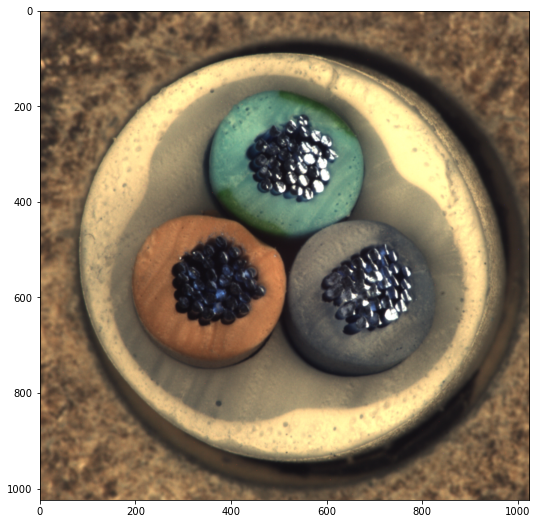

In [2]:
image = '022.png'
original_image = cv2.imread(image, 1)
plt.rcParams['figure.figsize'] = (16,9)
plt.imshow(original_image);

In [4]:
img=cv2.cvtColor(original_image,cv2.COLOR_BGR2RGB)

vectorized = img.reshape((-1,3))
vectorized = np.float32(vectorized)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

K = 3
attempts=10
ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)

center = np.uint8(center)

res = center[label.flatten()]
result_image = res.reshape((img.shape))

En primera instancia realizaremos una clusterización mediante kmeans, para observar como queda nuestra imagen original después de aplicar un algoritmo de clasificación no supervisada, que agrupa objetos en k grupos, basado en sus características.

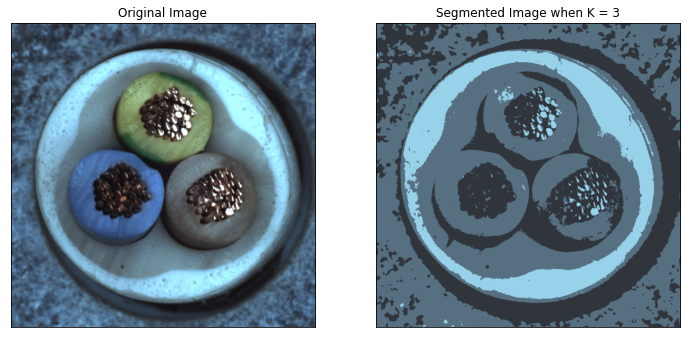

In [6]:
figure_size = 12
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(result_image)
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()

Con K=3, seleccionado de forma arbitraria en primera instancia, para poder observar grandes grupos, vemos que segmenta muy bien los componentes internos del cable.

En segunda instancia utilizaremos el detector de bordes Canny, que es un algoritmo que posee varias etapas: reducción de ruido, encontrar el gradiente de intensidad de imágen, se eliminan los píxeles no deseados y Hysteresis Thresholding, donde finalmente se determina que bordes son realmente bordes de acuerdo a un umbral minVal y maxVal.

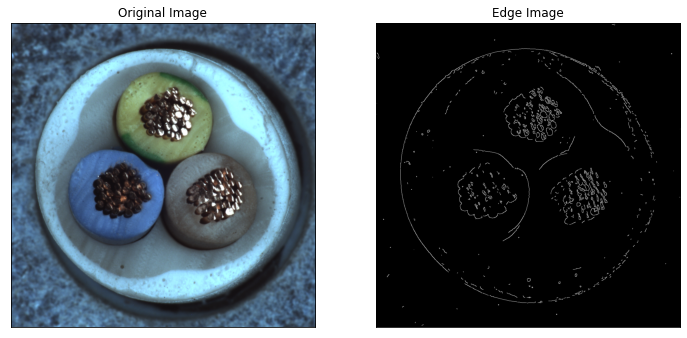

In [7]:
edges = cv2.Canny(img,150,200)
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

Como siguiente prueba, realizaremos una binarización de la imagen, ya que debiera ser más fácil trabajar con dimensiones normalizadas.

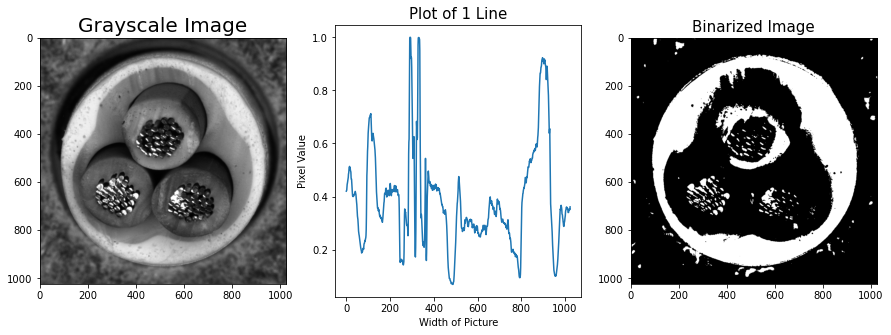

In [12]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

image = imread('086.png')
img_g = rgb2gray(image)
img_b = img_g > 0.5
ax[0].set_title('Grayscale Image',fontsize=20)
ax[0].imshow(img_g,cmap='gray')
ax[1].plot(img_g[600])
ax[1].set_ylabel('Pixel Value')
ax[1].set_xlabel('Width of Picture')
ax[1].set_title('Plot of 1 Line',fontsize=15)
ax[2].set_title('Binarized Image',fontsize=15)
ax[2].imshow(img_b,cmap='gray')
plt.show()

Luego, con la imagen normalizada, aplicamos otro filtro mediante blob usando el método Laplaciano de Gauss y dibujamos los círculos detectados. Usamos un umbral en el valor de píxel de 0,5, ya que en la gráfica se observa una separación en este nivel. Además, podemos obervas que el círculo inferior de la derecha tiene corte en pixel más bajo, por eso se ve más profundo.

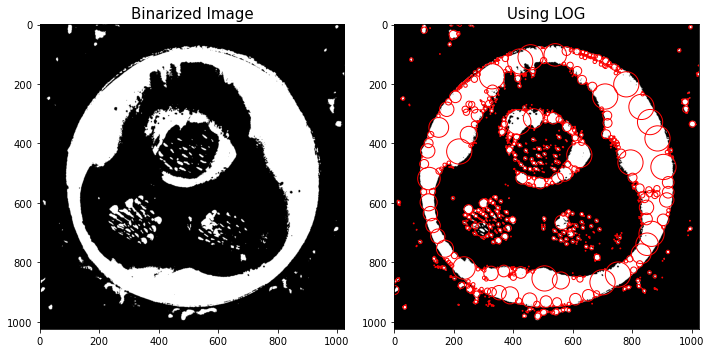

In [13]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].set_title('Binarized Image',fontsize=15)
ax[0].imshow(img_b,cmap='gray')
blobs = blob_log(img_b, max_sigma=30, threshold=0.01)
ax[1].imshow(img_b, cmap='gray')
for blob in blobs:
    y, x, area = blob
    ax[1].add_patch(plt.Circle((x, y), area*np.sqrt(2), color='r', 
                            fill=False))
ax[1].set_title('Using LOG',fontsize=15)
plt.tight_layout()
plt.show()

Luego, aplicamos otro filtro mediante blob usando la diferencia de gaussiana y dibujamos los círculos detectados.

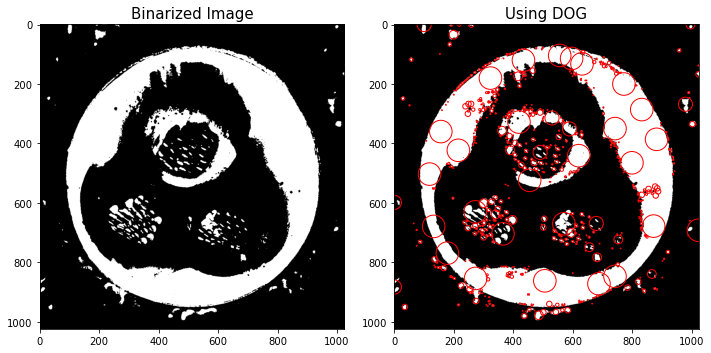

In [14]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].set_title('Binarized Image',fontsize=15)
ax[0].imshow(img_b,cmap='gray')
blobs = blob_dog(img_b, max_sigma=30, threshold=0.01)
ax[1].imshow(img_b, cmap='gray')
for blob in blobs:
    y, x, area = blob
    ax[1].add_patch(plt.Circle((x, y), area*np.sqrt(2), color='r', 
                            fill=False))
ax[1].set_title('Using DOG',fontsize=15)
plt.tight_layout()
plt.show()

Después, probamos los métodos anteriores más la determinante de la matriz hessiana sobre la imagen en escala de grises. Calculando los radios en la 3ra columna y normalizando y escalando el parámetro para que sea congruente.

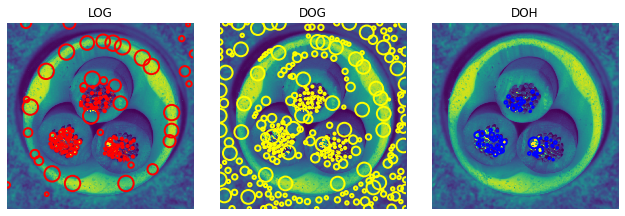

In [16]:
blobs_log = blob_log(img_g, max_sigma=30, num_sigma=10, threshold=.1)

blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)
blobs_dog = blob_dog(img_g, max_sigma=30, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)
blobs_doh = blob_doh(img_g, max_sigma=30, threshold=.01)
blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['red', 'yellow', 'blue']
titles = ['LOG', 'DOG','DOH']
          
sequence = zip(blobs_list, colors, titles)
fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()
for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(img_g, interpolation='nearest')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()
plt.tight_layout()
plt.show()

Luego, hacemos la misma operación pero para la imagen binarizada.

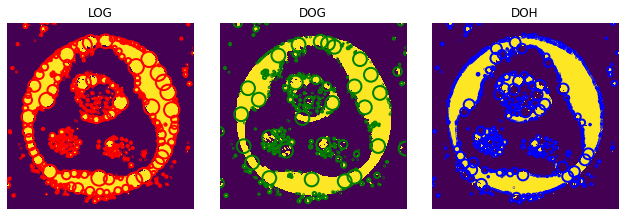

In [19]:
blobs_log = blob_log(img_b, max_sigma=30, num_sigma=10, threshold=.1)

blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)
blobs_dog = blob_dog(img_b, max_sigma=30, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)
blobs_doh = blob_doh(img_b, max_sigma=30, threshold=.01)
blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['red', 'green', 'blue']
titles = ['LOG', 'DOG','DOH']

sequence = zip(blobs_list, colors, titles)
fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()
for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(img_b, interpolation='nearest')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()
plt.tight_layout()
plt.show()

Finalmente hacemos la prueba con la imagen que logramos a través del algoritmo detector de bordes Canny.

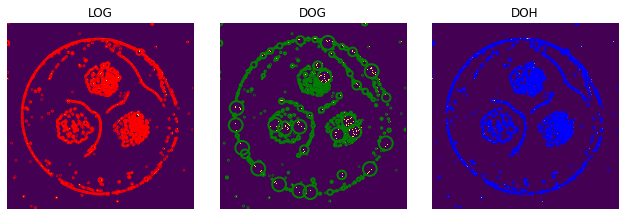

In [21]:
blobs_log = blob_log(edges, max_sigma=30, num_sigma=10, threshold=.1)

blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)
blobs_dog = blob_dog(edges, max_sigma=30, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)
blobs_doh = blob_doh(edges, max_sigma=30, threshold=.01)
blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['red', 'green', 'blue']
titles = ['LOG', 'DOG','DOH']

sequence = zip(blobs_list, colors, titles)
fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()
for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(edges, interpolation='nearest')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()
plt.tight_layout()
plt.show()

Como conclusión podemos decir que logramos realizar un procesamiento más avanzado que en la tarea anterior, con las mismas imágenes, se probaron varios métodos y se fueron visualizando, permitiendo evaluar el desempeño de varios algoritmos. Podemos decir que la última operación abarca tanto la detección de los círculos grandes tanto como los pequeños cables, por lo que sería adecuado para una implementación más avanzada dependiendo del objetivo. Mediante el método DOH en la imagen en escala de grises, se detectó muy bien sólo los pequeños cables, por lo que dependiendo de la aplicación, podría ser efectivo.